In [1]:
'''
Kaggle タイタニック生存予測（回帰）

参考: 【Kaggle初心者入門編】タイタニック号で生き残るのは誰？
URL: https://www.codexa.net/kaggle-titanic-beginner/

現在の最高: 0.8038277511961722（400位/50000くらいとの事）
データの加工法や特徴量の取り方が悪いのかなかなかこれ以上行かず。難しいですね

前回の人物判定に続き、機械学習2個目のチャレンジです

test.csv（正解が含まれていない、架空のデータ？）の人員の生存を機械学習で予測させる
あくまでtrain.csvは学習用のデータであり、test.csvには正解が含まれていないため半教師あり学習になるのでしょうか

本来正解のcsvはありませんが、一日にKaggleにアップロード可能な回数の制限があり、
時間もかかるため他の方のを参考に正解のcsvを作成
一部のみ除き、ほぼ自力でソースを作っています

・流れ
    1: csv取り込み
    2: データ加工
    3: ループを重ねて様々なパターンで結果を取得
    4: 一番正解率が高かった組み合わせにてアップロード用csvを作成
    
後日、他にも試したい欠損値埋めの方法や、アルゴリズム等が出てくるかもしれないので、
最小限の変更のみで済む様にソースを組みました。フラグや配列等で管理

前半部分について、比較しやすい様に順番を入れ替えています

各種アルゴリズムのパラメータについて、もっと値を大きくしたいのですが、
僕のPCがなかなかな事になるためにあまり大きく出来ず。。。
'''

'\nKaggle タイタニック生存予測（回帰）\n\n参考: 【Kaggle初心者入門編】タイタニック号で生き残るのは誰？\nURL: https://www.codexa.net/kaggle-titanic-beginner/\n\n現在の最高: 0.8038277511961722（400位/50000くらいとの事）\nデータの加工法や特徴量の取り方が悪いのかなかなかこれ以上行かず。難しいですね\n\n前回の人物判定に続き、機械学習2個目のチャレンジです\n\ntest.csv（正解が含まれていない、架空のデータ？）の人員の生存を機械学習で予測させる\nあくまでtrain.csvは学習用のデータであり、test.csvには正解が含まれていないため半教師あり学習になるのでしょうか\n\n本来正解のcsvはありませんが、一日にKaggleにアップロード可能な回数の制限があり、\n時間もかかるため他の方のを参考に正解のcsvを作成\n一部のみ除き、ほぼ自力でソースを作っています\n\n・流れ\n    1: csv取り込み\n    2: データ加工\n    3: ループを重ねて様々なパターンで結果を取得\n    4: 一番正解率が高かった組み合わせにてアップロード用csvを作成\n    \n後日、他にも試したい欠損値埋めの方法や、アルゴリズム等が出てくるかもしれないので、\n最小限の変更のみで済む様にソースを組みました。フラグや配列等で管理\n\n前半部分について、比較しやすい様に順番を入れ替えています\n\n各種アルゴリズムのパラメータについて、もっと値を大きくしたいのですが、\n僕のPCがなかなかな事になるためにあまり大きく出来ず。。。\n'

In [2]:
import pandas as pd
import numpy as np
train = pd.read_csv("./titanic/train.csv")
test = pd.read_csv("./titanic/test.csv")

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [3]:
# 欠損数&％表示用。train.isnull().sum()は不使用
def missing_table(df): 
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    missing_table = pd.concat([null_val, percent], axis = 1)
    missing_table_ren_columns = missing_table.rename(columns = {0: "欠損数", 1: "%"})
    return missing_table_ren_columns


# 文字列を数値に変更する用
def type_conversion():
    # trainの処理
    train.loc[train["Sex"] == "male", "Sex"] = 0
    train.loc[train["Sex"] == "female", "Sex"] = 1
    train.loc[train["Embarked"] == "S", "Embarked"] = 0
    train.loc[train["Embarked"] == "C", "Embarked"] = 1
    train.loc[train["Embarked"] == "Q", "Embarked"] = 2

    # train Ticketの処理
    tmp_ticket = []
    for i in train.loc[:, "Ticket"]:
        tmp_list = i.split(" ")
        if(len(tmp_list) == 1):
            if tmp_list[0] != "LINE":
                tmp_ticket.append(int(tmp_list[0]))
            else:
                tmp_ticket.append(np.nan)
        else:
            tmp_ticket.append(int(tmp_list[-1]))
    else:
        for i, v in enumerate(train["Ticket"]):
            train.loc[i, "Ticket"] = tmp_ticket[i]

    # train Cabinの処理。複数部屋番号がある場合、部屋が近い様なので平均値で統一
    tmp_cabin = []
    for i in train.loc[:, "Cabin"]:
        tmp_list = []
        if type(i) != float:
            tmp_list = i.split(" ")
            for j, v in enumerate(tmp_list):
                if len(str(v)) == 1:
                    tmp_list[j] = 0
                else:
                    tmp_list[j] = int(v[1:])
            else:
                tmp_cabin.append(int(np.mean(tmp_list)))
        else:
            tmp_cabin.append(0)
    else:
        for i, v in enumerate(train["Cabin"]):
            train.loc[i, "Cabin"] = tmp_cabin[i]

    # testの処理
    test.loc[test["Sex"] == "male", "Sex"] = 0
    test.loc[test["Sex"] == "female", "Sex"] = 1
    test.loc[test["Embarked"] == "S", "Embarked"] = 0
    test.loc[test["Embarked"] == "C", "Embarked"] = 1
    test.loc[test["Embarked"] == "Q", "Embarked"] = 2

    # test Ticketの処理
    tmp_ticket = []
    for i in test.loc[:, "Ticket"]:
        tmp_list = i.split(" ")
        if(len(tmp_list) == 1):
            tmp_ticket.append(int(tmp_list[0]))
        else:
            tmp_ticket.append(int(tmp_list[-1]))
    else:
        for i, v in enumerate(test["Ticket"]):
            test.loc[i, "Ticket"] = tmp_ticket[i]

    # test Cabinの処理。複数部屋番号がある場合、部屋が近い様なので平均値で統一
    tmp_cabin = []
    for i in test.loc[:, "Cabin"]:
        tmp_list = []
        if type(i) != float:
            tmp_list = i.split(" ")
            for j, v in enumerate(tmp_list):
                if len(str(v)) == 1:
                    tmp_list[j] = 0
                else:
                    tmp_list[j] = int(v[1:])
            else:
                tmp_cabin.append(int(np.mean(tmp_list)))
        else:
            tmp_cabin.append(0)
    else:
        for i, v in enumerate(test["Cabin"]):
            test.loc[i, "Cabin"] = tmp_cabin[i]


# 欠損値処理用 flag_num: 0 = mean（平均値）, 1 = median（中央値）, 2 = mode().iloc[0, :]（最頻値）
def fill_candidate(flag_num):
    if flag_num == 0:
        return [train.fillna(train.mean()), test.fillna(test.mean())]
    elif flag_num == 1:
        return [train.fillna(train.median()), test.fillna(test.median())]
    elif flag_num == 2:
        return [train.fillna(train.mode().iloc[0, :]), test.fillna(test.mode().iloc[0, :])]

In [4]:
print("\033[1m" + "\033[41m" + "元train:" + "\033[0m")
train

元train:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [16]:
print("\033[1m" + "\033[43m" + "加工後train(mean):" + "\033[0m")
example_train

加工後train(mean):


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,21171.0,7.2500,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,17599.0,71.2833,85,1.0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,3101282.0,7.9250,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803.0,53.1000,123,0.0
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450.0,8.0500,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.000000,0,0,211536.0,13.0000,0,0.0
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.000000,0,0,112053.0,30.0000,42,0.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.699118,1,2,6607.0,23.4500,0,0.0
889,890,1,1,"Behr, Mr. Karl Howell",0,26.000000,0,0,111369.0,30.0000,148,1.0


In [7]:
print("\033[1m" + "\033[41m" + "元train:" + "\033[0m")
train.dtypes

元train:


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [19]:
print("\033[1m" + "\033[43m" + "加工後train(mean):" + "\033[0m")
example_train.dtypes

加工後train(mean):


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket         float64
Fare           float64
Cabin            int64
Embarked       float64
dtype: object

In [6]:
print("\033[1m" + "\033[41m" + "元train:" + "\033[0m")
missing_table(train)

元train:


,欠損数,%
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,177,19.865320
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,0,0.000000


In [18]:
print("\033[1m" + "\033[43m" + "加工後train(mean):" + "\033[0m")
missing_table(example_train)

加工後train(mean):


,欠損数,%
PassengerId,0,0.0
Survived,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0


In [5]:
print("\033[1m" + "\033[41m" + "元train:" + "\033[0m")
train.describe()

元train:


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [17]:
print("\033[1m" + "\033[43m" + "加工後train(mean):" + "\033[0m")
example_train.describe()

加工後train(mean):


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,0.352413,29.699118,0.523008,0.381594,2.983284e+05,32.204208,11.214366,0.362205
std,257.353842,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,6.561349e+05,49.693429,26.727086,0.635442
min,1.000000,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,3.000000e+00,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,1.487900e+04,7.910400,0.000000,0.000000
50%,446.000000,0.000000,3.000000,0.000000,29.699118,0.000000,0.000000,1.130280e+05,14.454200,0.000000,0.000000
75%,668.500000,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,3.470820e+05,31.000000,0.000000,1.000000
max,891.000000,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,3.101317e+06,512.329200,148.000000,2.000000


元train:


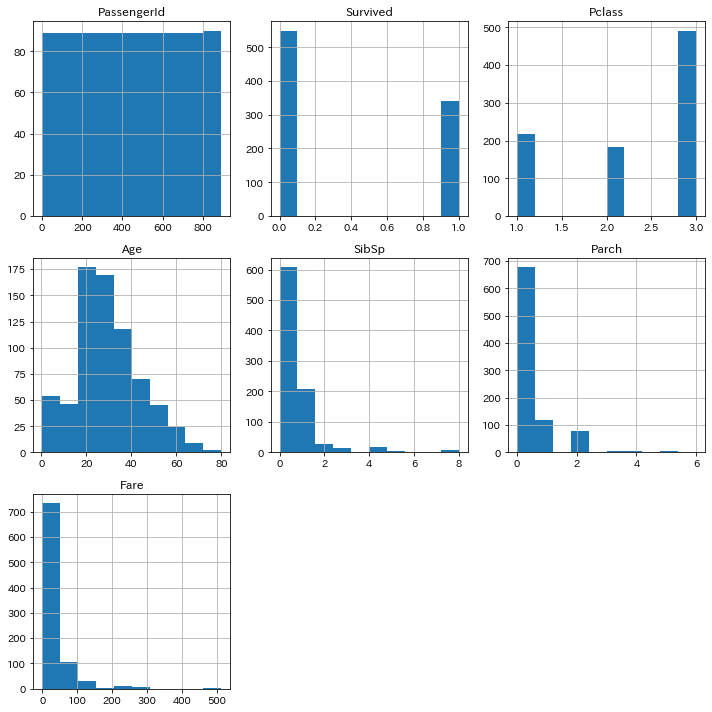

In [8]:
print("\033[1m" + "\033[41m" + "元train:" + "\033[0m")
train.hist()
plt.tight_layout()
plt.show()

加工後train(mean):


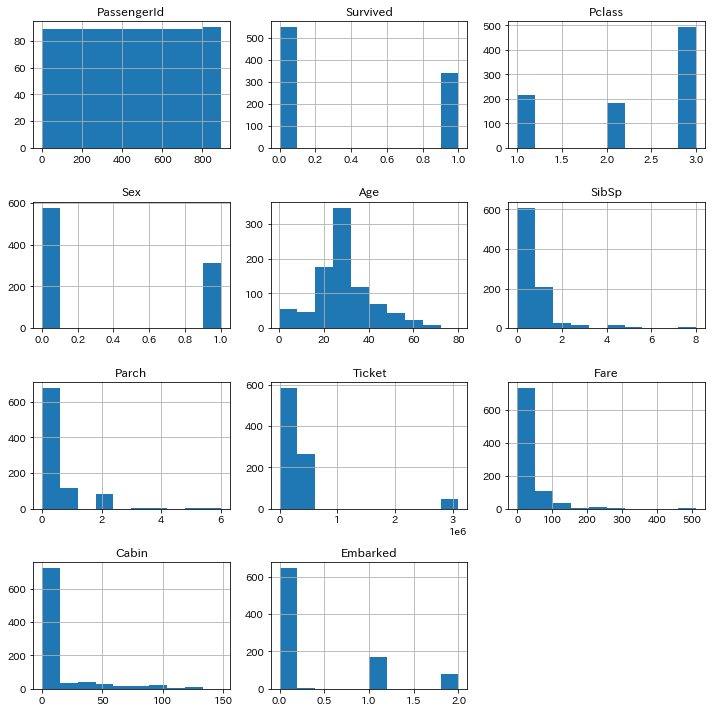

In [20]:
print("\033[1m" + "\033[43m" + "加工後train(mean):" + "\033[0m")
example_train.hist()
plt.tight_layout()
plt.show()

In [9]:
print("\033[1m" + "\033[42m" + "元test:" + "\033[0m")
test

元test:


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [21]:
print("\033[1m" + "\033[44m" + "加工後test(mean):" + "\033[0m")
example_test

加工後test(mean):


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",0,34.50000,0,0,330911,7.8292,0,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47.00000,1,0,363272,7.0000,0,0
2,894,2,"Myles, Mr. Thomas Francis",0,62.00000,0,0,240276,9.6875,0,2
3,895,3,"Wirz, Mr. Albert",0,27.00000,0,0,315154,8.6625,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22.00000,1,1,3101298,12.2875,0,0
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",0,30.27259,0,0,3236,8.0500,0,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",1,39.00000,0,0,17758,108.9000,105,1
415,1307,3,"Saether, Mr. Simon Sivertsen",0,38.50000,0,0,3101262,7.2500,0,0
416,1308,3,"Ware, Mr. Frederick",0,30.27259,0,0,359309,8.0500,0,0


In [12]:
print("\033[1m" + "\033[42m" + "元test:" + "\033[0m")
test.dtypes

元test:


PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [24]:
print("\033[1m" + "\033[44m" + "加工後test(mean):" + "\033[0m")
example_test.dtypes

加工後test(mean):


PassengerId      int64
Pclass           int64
Name            object
Sex              int64
Age            float64
SibSp            int64
Parch            int64
Ticket           int64
Fare           float64
Cabin            int64
Embarked         int64
dtype: object

In [11]:
print("\033[1m" + "\033[42m" + "元test:" + "\033[0m")
missing_table(test)

元test:


,欠損数,%
PassengerId,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
Age,86,20.574163
SibSp,0,0.000000
Parch,0,0.000000
Ticket,0,0.000000
Fare,1,0.239234
Cabin,327,78.229665


In [23]:
print("\033[1m" + "\033[44m" + "加工後test(mean):" + "\033[0m")
missing_table(example_test)

加工後test(mean):


,欠損数,%
PassengerId,0,0.0
Pclass,0,0.0
Name,0,0.0
Sex,0,0.0
Age,0,0.0
SibSp,0,0.0
Parch,0,0.0
Ticket,0,0.0
Fare,0,0.0
Cabin,0,0.0


In [10]:
print("\033[1m" + "\033[42m" + "元test:" + "\033[0m")
test.describe()

元test:


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [22]:
print("\033[1m" + "\033[44m" + "加工後test(mean):" + "\033[0m")
example_test.describe()

加工後test(mean):


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,4.180000e+02,418.000000,418.000000,418.000000
mean,1100.500000,2.265550,0.363636,30.272590,0.447368,0.392344,2.534044e+05,35.627188,10.011962,0.464115
std,120.810458,0.841838,0.481622,12.634534,0.896760,0.981429,5.876873e+05,55.840500,23.955541,0.685516
min,892.000000,1.000000,0.000000,0.170000,0.000000,0.000000,2.000000e+00,0.000000,0.000000,0.000000
25%,996.250000,1.000000,0.000000,23.000000,0.000000,0.000000,1.350800e+04,7.895800,0.000000,0.000000
50%,1100.500000,3.000000,0.000000,30.272590,0.000000,0.000000,3.560950e+04,14.454200,0.000000,0.000000
75%,1204.750000,3.000000,1.000000,35.750000,1.000000,0.000000,3.455002e+05,31.500000,0.000000,1.000000
max,1309.000000,3.000000,1.000000,76.000000,8.000000,9.000000,3.101315e+06,512.329200,132.000000,2.000000


元test:


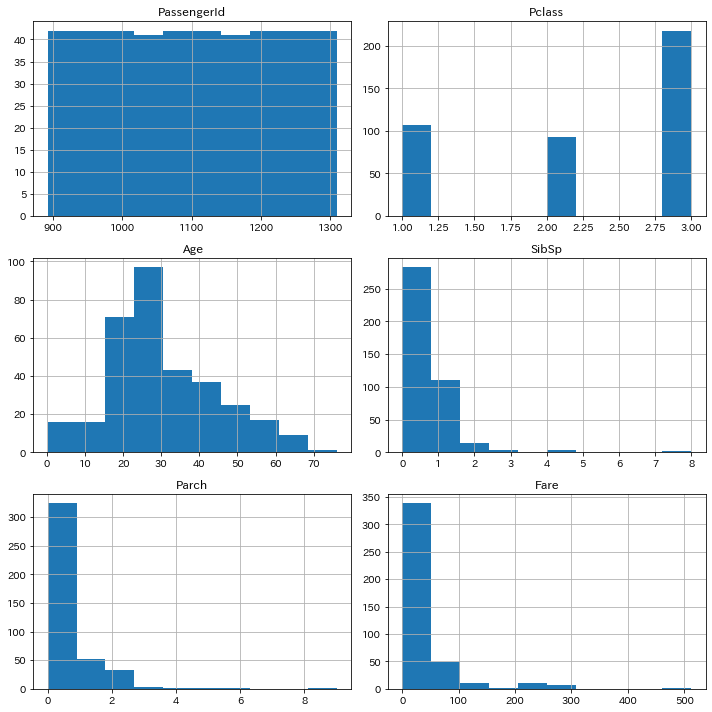

In [13]:
print("\033[1m" + "\033[42m" + "元test:" + "\033[0m")
test.hist()
plt.tight_layout()
plt.show()

加工後test(mean):


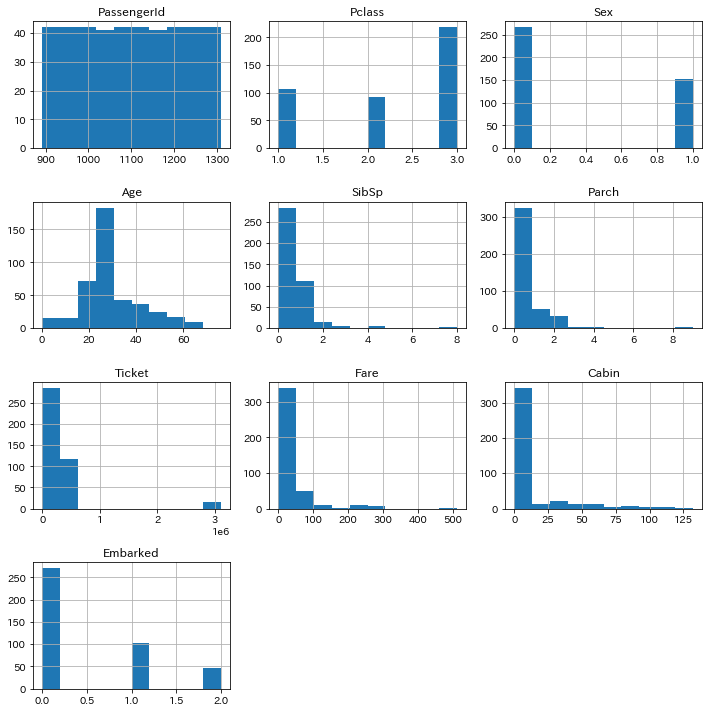

In [25]:
print("\033[1m" + "\033[44m" + "加工後test(mean):" + "\033[0m")
example_test.hist()
plt.tight_layout()
plt.show()

In [14]:
type_conversion()

In [15]:
# fill_candidate()の都合で、加工後例として(mean)
example_after_processing_mean = fill_candidate(0)
example_train = example_after_processing_mean[0]
example_test = example_after_processing_mean[1]

C:\Users\work\AppData\Local\Temp/ipykernel_9048/2204944638.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return [train.fillna(train.mean()), test.fillna(test.mean())]


In [26]:
# 色々な組み合わせをループで回すための事前定義

answer = pd.read_csv("./answer_example.csv")

target = train["Survived"].values

fill_candidate_list = ["mean", "median", "mode"]

# itertoolsで全組み合わせを格納
import itertools
explanatory_variable_list = []
explanatory_word_list = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]

for i in range(1, len(explanatory_word_list) + 1):
    for conb in itertools.combinations(explanatory_word_list, i):
        explanatory_variable_list.append(list(conb))
        
#import pprint
#pprint.pprint(explanatory_variable_list)

sklearn_list = ["tree_1", "tree_2", "rfc_1", "rfc_2"]

In [27]:
# ループ用のアルゴリズム選択用。パラメータを大きい数字でやりたいが、PC的に厳しいため軽量で
def sklearn_select(flag_num, features, test_features):
    if flag_num == 0:
        # 決定木のみ
        from sklearn import tree
        algorithm = tree.DecisionTreeClassifier(
            max_depth = 20,
            min_samples_leaf = 5,
            min_samples_split = 3,

            random_state = 123
        )

    elif flag_num == 1:
        # 決定木&グリッドサーチ
        from sklearn.model_selection import GridSearchCV
        from sklearn import tree
        param = {
#           "max_depth": [1, 2],
#           "min_samples_leaf": [1, 2],
#           "min_samples_split": [2, 3],

            "max_depth": [1, 2, 3, 4, 5, 10],
            "min_samples_leaf": [1, 2, 3, 5],
            "min_samples_split": [2, 3, 4, 5],
        }
        algorithm = GridSearchCV(
#           tree.DecisionTreeClassifier(random_state = 123), param, cv = 2, n_jobs = -1, refit = True
#           tree.DecisionTreeClassifier(random_state = 123), param, cv = 2, verbose = 3, n_jobs = -1, refit = True

            tree.DecisionTreeClassifier(random_state = 123), param, cv = 5, n_jobs = -1, refit = True
#            tree.DecisionTreeClassifier(random_state = 123), param, cv = 5, verbose = 3, n_jobs = -1, refit = True
        )

    elif flag_num == 2:
        # ランダムフォレストのみ
        from sklearn.ensemble import RandomForestClassifier
        algorithm = RandomForestClassifier(
            n_estimators = 20,
            max_depth = 10,

#            n_estimators = 100,
#            max_depth = 10,

            random_state = 123
        )

    elif flag_num == 3:
        # ランダムフォレスト&グリッドサーチ
        from sklearn.model_selection import GridSearchCV
        from sklearn.ensemble import RandomForestClassifier

        param = {
#           "n_estimators": [1, 3],
#           "max_depth"   : [1, 2],
#           "max_features": ["sqrt", "log2", None]

            "n_estimators": [1, 10, 30],
            "max_depth"   : [1, 10, 30],
            "max_features": ["sqrt", "log2", None]
        }
        algorithm = GridSearchCV(
#            RandomForestClassifier(random_state = 123), param, cv = 2, n_jobs = -1, refit = True
#           RandomForestClassifier(random_state = 123), param, cv = 2, verbose = 3, n_jobs = -1, refit = True

            RandomForestClassifier(random_state = 123), param, cv = 5, n_jobs = -1, refit = True
#            RandomForestClassifier(random_state = 123), param, cv = 5, verbose = 3, n_jobs = -1, refit = True

        )
        
    algorithm.fit(features, target)
    prediction = algorithm.predict(test_features)

    return prediction

In [28]:
# やりたかった事のために4重ループ
result_score = []

# 欠損値埋め方法選択のループ
for i in range(len(fill_candidate_list)):
    fill_list = fill_candidate(i)
    fill_name = fill_candidate_list[i]
    
    # 説明変数選択のループ
    for j in range(len(explanatory_variable_list)):
        features = fill_list[0][explanatory_variable_list[j]].values
        test_features = fill_list[1][explanatory_variable_list[j]].values

        # アルゴリズム選択のループ
        for k in range(len(sklearn_list)):
            prediction = sklearn_select(k, features, test_features)
            algorithm_name = sklearn_list[k]

            # 正解率取得用ループ
            correct_count = 0        
            for s in zip(test["PassengerId"], answer["Survived"], prediction):
                if s[1] == s[2]:
                    correct_count += 1    
            else:
                result_score.append([fill_name, j, algorithm_name, correct_count / len(test), explanatory_variable_list[j]])

C:\Users\work\AppData\Local\Temp/ipykernel_9048/2204944638.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return [train.fillna(train.mean()), test.fillna(test.mean())]
C:\Users\work\AppData\Local\Temp/ipykernel_9048/2204944638.py:97: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return [train.fillna(train.median()), test.fillna(test.median())]
C:\Users\work\AppData\Local\Temp/ipykernel_9048/2204944638.py:97: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return [train.fillna(train

In [29]:
#pd.set_option("display.max_rows", None)

print("\033[1m" + "\033[45m" + "実施結果の一覧:" + "\033[0m")
processing_df = pd.DataFrame(result_score, columns = ["欠損値", "説明変数", "アルゴリズム", "正解率", "説明変数詳細"])
processing_df

実施結果の一覧:


,欠損値,説明変数,アルゴリズム,正解率,説明変数詳細
0,mean,0,tree_1,0.672249,[Pclass]
1,mean,0,tree_2,0.602871,[Pclass]
2,mean,0,rfc_1,0.672249,[Pclass]
3,mean,0,rfc_2,0.672249,[Pclass]
4,mean,1,tree_1,0.765550,[Sex]
...,...,...,...,...,...
6127,mode,509,rfc_2,0.767943,"[Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, ..."
6128,mode,510,tree_1,0.758373,"[Pclass, Sex, Age, SibSp, Parch, Ticket, Fare,..."
6129,mode,510,tree_2,0.758373,"[Pclass, Sex, Age, SibSp, Parch, Ticket, Fare,..."
6130,mode,510,rfc_1,0.789474,"[Pclass, Sex, Age, SibSp, Parch, Ticket, Fare,..."


In [30]:
print("\033[1m" + "\033[45m" + "最高正解率:" + "\033[0m")
high_score = max(processing_df["正解率"])
high_score

最高正解率:


0.8038277511961722

In [31]:
print("\033[1m" + "\033[45m" + "最高正解率の行を取得:" + "\033[0m")
high_score_row = processing_df.loc[processing_df["正解率"] == high_score].index[0]
high_score_row = processing_df.loc[processing_df.index == high_score_row]
high_score_row

最高正解率の行を取得:


,欠損値,説明変数,アルゴリズム,正解率,説明変数詳細
2022,mean,505,rfc_1,0.803828,"[Pclass, Sex, Age, SibSp, Ticket, Fare, Cabin,..."


In [32]:
print("\033[1m" + "\033[45m" + "最高正解率の組み合わせ:" + "\033[0m")
high_score_parts = high_score_row.values.tolist()[0]
high_score_parts = [high_score_parts[0], high_score_parts[2], high_score_parts[4]]
high_score_parts

最高正解率の組み合わせ:


['mean',
 'rfc_1',
 ['Pclass', 'Sex', 'Age', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked']]

In [33]:
# ↓でcsvファイルを作成するため、再び最高正解率の組み合わせで1回分回すために定義
high_score_parts_index_list = [
    fill_candidate_list.index(high_score_parts[0]),
    sklearn_list.index(high_score_parts[1]),
    high_score_parts[2]
]
#high_score_parts_index_list

In [34]:
print("\033[1m" + "\033[46m" + "正解率再確認（正しく↑と合致するかの確認）:" + "\033[0m")

# 最高正解率の組み合わせのために定義し直し
result_fill_list = fill_candidate(high_score_parts_index_list[0])
result_features = result_fill_list[0][high_score_parts_index_list[2]].values
result_test_features = result_fill_list[1][high_score_parts_index_list[2]].values
result_prediction = sklearn_select(high_score_parts_index_list[1], result_features, result_test_features)

# 念のため正しく取れているかの確認用
result_correct_count = 0
for i in zip(test["PassengerId"], answer["Survived"], result_prediction):
    if i[1] == i[2]:
        result_correct_count += 1
else:
    print(result_correct_count / len(test))

正解率再確認（正しく↑と合致するかの確認）:
0.8038277511961722


C:\Users\work\AppData\Local\Temp/ipykernel_9048/2204944638.py:95: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return [train.fillna(train.mean()), test.fillna(test.mean())]


In [35]:
# Kaggleにアップロードするための.csv生成用
PassengerId = np.array(test["PassengerId"]).astype(int)
my_solution_tree = pd.DataFrame(result_prediction, PassengerId, columns = ["Survived"])
my_solution_tree.to_csv("submission.csv", index_label = ["PassengerId"])

現時点での最高記録:


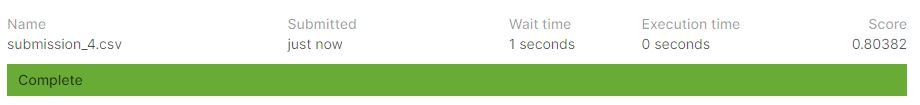

In [36]:
print("\033[1m" + "\033[47m" + "現時点での最高記録:" + "\033[0m")

from PIL import Image
Image.open("./result_score.JPG")